### Visualization Performance


In [57]:
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import itertools
from matplotlib import pyplot as plt
import matplotlib.dates as mdate
import matplotlib.dates as mdates
import glob
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
import tensorflow as tf

from utility.utility import *
from utility.techIndex import talib_index
from utility.model import dnn, lstm, conv1d, conv2d, transformer

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import configparser
config = configparser.ConfigParser()
config.read('config.ini')

['config.ini']

In [58]:
# get last weight
newest = True

test_weight = {
    # 'transformer': '',
    # 'conv1d': '',
    # 'conv2d': '',
    # 'dnn': '',
    'lstm': ''
 }
# # test data
# stock = 'TWII_test.csv'

if newest:
    for model, folder in test_weight.items(): 
        # test_weight[model] = glob.glob(f'model/{model}/*/')[-1][:-1]
        test_weight[model] = glob.glob(f'model/{model}/*.index')[-1][:-6]

# window length
# slide = 30

df = read_data(config, 'test')
model_metric = {}
test_weight

data\NFLX_test.csv


{'lstm': 'model/lstm\\20221005-005248_NFLX_e20_s30'}

### Predict Price

In [62]:
%%time

X, y = label(df)
# X_dim = X.index
X_scaler, y_scaler = scaler(X, y, config, 'test')
# sns.set_palette("tab10")
metric = pd.DataFrame({'bench mark':y[int(config['MODEL']['slide']):]})

for model_name, weight in test_weight.items(): 
    X_, y_ = training_window(X_scaler, y_scaler , config, model_name)
    model = load_model(X_.shape, model_name)
    model.load_weights(test_weight[model_name])
    print('000')
    y_pred = model.predict(X_)
    if bool(config["STOCK"]["scale"]):
        y_pred = inverse_predict(y_pred, config)
    # print(type(y_pred),y_pred[:5])
    metric[model_name] = y_pred
    # mse = mean_squared_error(y[int(config['MODEL']['slide']):], y_pred, squared=False)   
    print('111')
    
display(metric)




scale

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_92 (LSTM)              (None, 30, 128)           69120     
                                                                 
 lstm_93 (LSTM)              (None, 30, 128)           131584    
                                                                 
 batch_normalization_46 (Bat  (None, 30, 128)          512       
 chNormalization)                                                
                                                                 
 dropout_46 (Dropout)        (None, 30, 128)           0         
                                                                 
 lstm_94 (LSTM)              (None, 30, 128)           131584    
                                                                 
 lstm_95 (LSTM)              (None, 30, 128)           131584    
                                             

,bench mark,lstm
Date,,
2022-02-16,407.459991,204.969910
2022-02-17,398.079987,204.058517
2022-02-18,386.670013,203.435791
2022-02-22,391.290009,202.878494
2022-02-23,377.380005,202.372498
...,...,...
2022-09-28,224.360001,189.033096
2022-09-29,245.199997,188.929199
2022-09-30,239.710007,188.816635


CPU times: total: 2.28 s
Wall time: 2.51 s


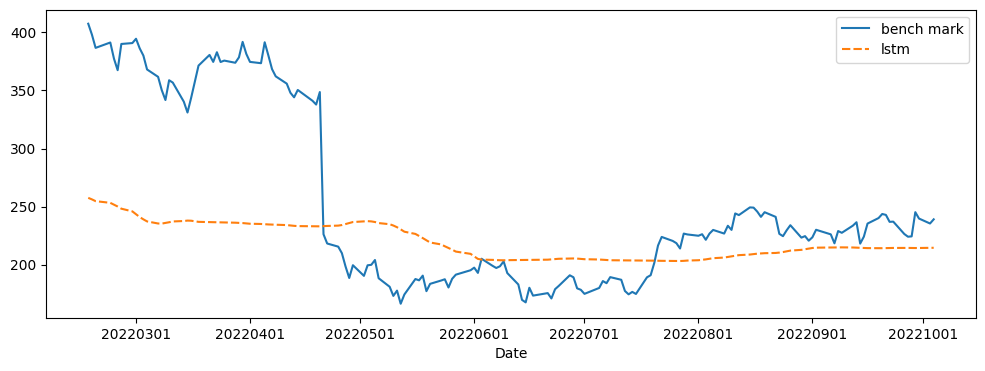

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4), dpi=100)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y%m%d'))
metric.index = pd.to_datetime(metric.index)
sns.lineplot(data=metric, ax=ax)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y%m%d'))
